# Μέρος 2ο - Ταξινόμηση εικόνων με συμβατικές τεχνικές ΑΠ

Στο δεύτερο μέρος καλείστε να επιλύσετε ένα πρόβλημα ταξινόμησης εικόνων
που προκύπτουν από αλγορίθμους ανίχνευσης προσώπων, με στόχο την
επιβεβαίωση χρήσης μάσκας. Αποτελούνται από 1044 εικόνες προσώπων χωρίς τη χρήση μάσκας(without_mask), ισάριθμες εικόνες προσώπων που χρησιμοποιούν μάσκα(with_mask) και 56 εικόνες προσώπων που χρησιμοποιούν μάσκα εσφαλμένα (mask_incorrect_use)

###a. Ως δεδομένα εκπαίδευσης, επικύρωσης και δοκιμής θα χρησιμοποιηθούν μόνο εικόνες από τις κλάσεις with_mask και without_mask με τις αντίστοιχες ετικέτες. Χωρίστε τα δεδομένα τυχαία σε 60% δεδομένα εκπαίδευσης, 20% δεδομένα επικύρωσης και 20% δεδομένα δοκιμής.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset, WeightedRandomSampler
import torchvision
from torch.autograd import Variable
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns

import PIL
from PIL import Image
import warnings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Αρχικά, κάνουμε import όλες τις απαραίτητες βιβλιοθήκες. Συγκεκριμένα, για την εισαγωγή των εικόνων ως dataset χρησιμοποιείται η Image. 

Ορίζουμε, τους μετασχηματισμούς που θέλουμε για τις εικόνες. Αυξάνουμε τις διαστάσεις τους, καθώς οι αρχικές διαστάσεις είναι 32x32 και δεν είναι ευδιάκριτες, οπότε τις μετατρέπουμε σε 224x224, κάνουμε Crop και Normalization όπως φαίνεται παρακάτω. 

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
])

Αρχικά, φορτώνουμε τις εικόνες μέσω zip στο drive και κάνουμε unzip. Στη συνέχεια, μέσω των shutil,os ορίζουμε το βασικό path του directory μας και μεταφέρουμε το subdirectory με το οποίο θα ασχοληθούμε αργότερα (mask_incorrect_use) σε νέο φάκελο με όνομα dest.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -u "/content/drive/My Drive/Mask_DB.zip" -d "/content/drive/My Drive/Mask_DB"

Mounted at /content/drive
Archive:  /content/drive/My Drive/Mask_DB.zip
   creating: /content/drive/My Drive/Mask_DB/without_mask/
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0002.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0030.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0031.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0033.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0034.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0036.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0038.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0042.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0057.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0059.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0061.jpg  
  inflating: /content/drive/My Drive/Mask_DB/without_mask/0068.jpg  
  inflating: /content/drive/My Drive/Mask

In [ ]:
# import shutil module
import shutil
 
# import os module
import os
 
# base path
base_path = '../content/drive/My Drive/Mask_DB'
 
# list of directories we want to move.
dir_list = ['mask_incorrect_use']
 
# path to destination directory
dest = os.path.join(base_path, 'dest')
 
print("Before moving directories:")
print(os.listdir(base_path))
 
# traverse each directory in dir_list
for dir_ in dir_list:
 
    # create path to the directory in the
    # dir_list.
    source = os.path.join(base_path, dir_)
 
    # check if it is an existing directory
    if os.path.isdir(source):
 
        # move to destination path
        shutil.move(source, dest)
 
print("After moving directories:")
print(os.listdir(base_path))

Before moving directories:
['without_mask', 'mask_incorrect_use', 'with_mask']
After moving directories:
['without_mask', 'dest', 'with_mask']


Στη συνέχεια, μεταφέρουμε όλα τα αρχεία μέσω της συνάρτησης move_files σε νέο φάκελο. Η διαδικασία έχει ως εξής: 
1. ορίζουμε την def move_files
2. μεταφέρουμε ολόκληρο τον φάκελο with_mask στον φάκελο merge.
3. ομοίως για τον φάκελο without_mask
Αυτή η διαδικασία γίνεται καθώς για να φορτώσουμε τις εικόνες σε dataset με την ImageFolder πρέπει τα δεδομένα μας να είναι σε μορφή: 
*/merge/with_mask/0001.png
/merge/without_mask/0002.png*

In [ ]:
target_folder = r'../content/drive/MyDrive/Mask_DB/merge/with_mask' + '//'
source_folder = r'../content/drive/MyDrive/Mask_DB/with_mask' + '//'



def move_files(sourceFolder,targetFolder):
    try:
         for path,dir,images in os.walk(sourceFolder):
           if images:
              for image in images:
                 if not os.path.isfile(targetFolder + image):
                    os.rename(path +'//'+ image,targetFolder +image)
         print('All files Moved')
    except Exception as e:
        print(e)
move_files(source_folder,target_folder)

All files Moved


In [ ]:
target_folder1 = r'../content/drive/MyDrive/Mask_DB/merge/without_mask' + '//'
source_folder1 = r'../content/drive/MyDrive/Mask_DB/without_mask' + '//'
move_files(source_folder1,target_folder1)

All files Moved


Ορίζουμε το path του φακέλου που θα χρησιμοποιήσουμε και μέσω της ImageFolder δημιουργόυμε το dataset και του εφαρμόζουμε τους μετασχηματισμούς που αναφέρθηκαν παραπάνω. 

In [ ]:
root_dest = '../content/drive/MyDrive/Mask_DB/merge'

In [ ]:
dataset = ImageFolder(root = root_dest, transform = transform)
dataset

Dataset ImageFolder
    Number of datapoints: 2088
    Root location: ../content/drive/MyDrive/Mask_DB/merge
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Ορίζουμε indexes για 1 όταν έχω μάσκα και 0 όταν δεν έχω.

In [ ]:
dataset.class_to_idx

dataset.class_to_idx = {'with_mask':1, 'without_mask':0}
dataset.class_to_idx

{'with_mask': 1, 'without_mask': 0}

In [ ]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
idx2class

{1: 'with_mask', 0: 'without_mask'}

In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(dataset))

Distribution of classes: 
 {'with_mask': 1044, 'without_mask': 1044}


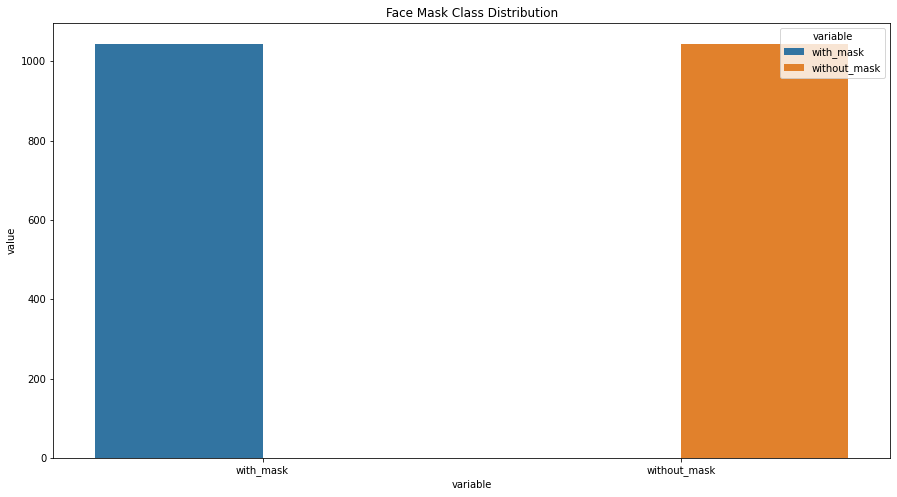

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Face Mask Class Distribution')
plt.show()

Χωρίζουμε το dataset σε 60%,20%,20% για το σύνολο εκπαίδευσης, επικύρωσης και δοκιμής μέσω της random_split 

In [ ]:
train_set_size = int(len(dataset) * 0.6)
rem_set_size = len(dataset) - train_set_size
train_dataset, remain_dataset = random_split(dataset, (1253, 835))
val_dataset, test_dataset = random_split(remain_dataset, (417,418))
print("Length of the train_loader:", len(test_dataset))

Length of the train_loader: 418


Στη συνέχεια, δημιουργώ DataLoaders για να τα χρησιμοποιήσω στο CNN παρακάτω. Όλα έχουν batch_size =1 καθώς δεν θέλω να περνάνε πολύ λίγα δεδομένα σε κάθε epoch, και num_workers = 2 

In [ ]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=1, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=1, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, shuffle=True, batch_size=1, num_workers=2)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 1253
Length of the val_loader: 417


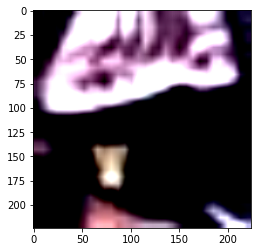

with_mask


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images

images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('with_mask', 'without_mask')
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))

###b. Υλοποιείστε και εκπαιδεύστε ένα σύστημα αναγνώρισης προτύπων που αποτελείται από ένα στάδιο ελάττωσης διαστάσεων των αρχικών δεδομένων και ένα στάδιο ταξινόμησης, χρησιμοποιώντας κατάλληλους αλγορίθμους της επιλογής σας. Δικαιολογήστε το σκεπτικό σας

Μέσω της class ορίζουμε ένα Convolutional Network. Στο πρώτο επίπεδο έχουμε 3 εισόδους (RGB εικόνες),έξοδο με 6 νευρώνες, φίλτρο 3x3 και stride = 1. Ομοίως, στο 2ο επίπεδο έχουμε ως είσοδο την έξοδο του προηγούμενου επιπέδου, δηλαδή 6, 16 νευρώνες εξόδου και 3x3 φίλτρο και stride = 1. Στο 1ο fully connected (fc) επίπεδο έχουμε 54*54*16 ως είσοδο, 224 - 2 γιατί δεν έχουμε padding, (224-2)/2 γιατί θα εφαρμοστεί max pool ( εδώ γίνεται η μείωση των διαστάσεων) ((224-2)/2)-2 γιατί δεν έχουμε padding ούτε στο 2ο επίπεδο, και /2 γιατί έχουμε max pool Άρα, έχω 54*54*16 και έξοδο 120 νευρώνες. Στο 2ο fc έχω 120 νευρώνες εισόδου και 84 εξόδου και στο 3ο fc έχουμε 84 νευρώνες εισόδου και 2 νευρώνες εξόδου - με μάσκα και χωρίς μάσκα.

In [ ]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, 1)
        self.conv2 = nn.Conv2d(10, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)
        self.fc4 = nn.Linear(42,2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 54*54*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

net = ConvolutionalNetwork()

Για την απώλεια ορίζουμε το criterion όπως φαίνεται παρακάτω και optimizer επιλέγεται ο Adam με ρυθμό μάθησης 0.001 και weight_decay = 0.0001

In [ ]:
torch.manual_seed(101)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay = 0.0001)

Mέσω της συνάρτησης count_parameters μετράμε τις παραμέτρους του δικτύου μας.

In [ ]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [ ]:
count_parameters(net)

     162
       6
     864
      16
 5598720
     120
   10080
      84
    3528
      42
      84
       2
________
 5613708


###c. Επιλέξτε τον βέλτιστο αριθμό ελάττωσης διαστάσεων (μεταξύ 2 και 100) και τις βέλτιστες παραμέτρους του ταξινομητή σας, χρησιμοποιώντας το σύνολο επικύρωσης, και στη συνέχεια υπολογίστε το σφάλμα ταξινόμησης στο σύνολο δοκιμής. Στη συνέχεια, εφαρμόστε το σύστημά σας στις εικόνες της κλάσης «mask_incorrect_use» και υπολογίστε το ποσοστό αυτών που ταξινομούνται ως αποδεκτή χρήση μάσκας. 

Αφού αναλύσαμε παραπάνω τις βέλτιστες παραμέτρους, εφαρμόζουμε το δίκτυο μας στο train_loader. 

In [ ]:
import time
start_time = time.time()

epochs = 3
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = net(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if (b+1) % 100 == 0:
            print(f'epoch: {i+1}   loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(1*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = net(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch: 1   loss: 0.00239276  accuracy:  96.970%
epoch: 1   loss: 0.16398118  accuracy:  96.985%
epoch: 1   loss: 0.01631199  accuracy:  95.987%
epoch: 1   loss: 0.00035256  accuracy:  96.241%
epoch: 1   loss: 0.00386872  accuracy:  95.591%
epoch: 1   loss: 0.00000393  accuracy:  95.492%
epoch: 1   loss: 0.00011157  accuracy:  95.136%
epoch: 1   loss: 0.00000763  accuracy:  94.994%
epoch: 1   loss: 0.02782724  accuracy:  95.217%
epoch: 1   loss: 0.00004089  accuracy:  95.395%
epoch: 1   loss: 0.00275161  accuracy:  95.541%
epoch: 1   loss: 1.07022977  accuracy:  95.580%
epoch: 2   loss: 0.13629210  accuracy:  92.929%
epoch: 2   loss: 0.83335477  accuracy:  93.467%
epoch: 2   loss: 0.00788268  accuracy:  94.649%
epoch: 2   loss: 1.09218693  accuracy:  93.233%
epoch: 2   loss: 0.00000000  accuracy:  93.788%
epoch: 2   loss: 0.01548541  accuracy:  93.990%
epoch: 2   loss: 0.00003123  accuracy:  94.134%
epoch: 2   loss: 0.00000072  accuracy:  94.743%
epoch: 2   loss: 7.54209995  accuracy:  

In [ ]:
net.eval()                                     # step i.
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = net(images)                      # step ii.
    _, predicted = torch.max(outputs.data, 1)  # step iii.
    total += labels.size(0)
    correct += (predicted == labels).sum()     # step iv.

print('Test Accuracy of the model on  test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on  test images: 95.9330 %


Στον πίνακα σύγχυσης παρατηρούμε τα σφάλματα ταξινόμησης για κάθε κλάση στο test set.

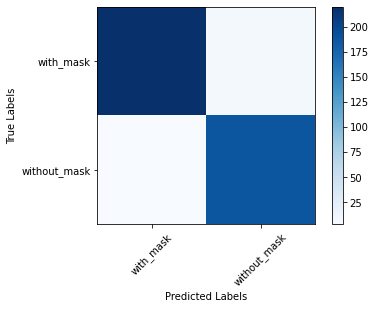

array([[ 220,    7],
       [   3,  188]])

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data to get true and predicted labels
for inputs, labels in test_loader:
        output = net(inputs) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save predicted labels
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save true labels
        
classes = ('with_mask', 'without_mask')

#Plot and compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
cm

In [ ]:
target_folder = r'../content/drive/MyDrive/Mask_DB/dest/mask_incorrect_use' + '//'
source_folder = r'../content/drive/MyDrive/Mask_DB/dest' + '//'
move_files(source_folder,target_folder)


All files Moved


Στη συνέχεια, αφού μεταφέρουμε τα incorrect_use_mask σε άλλο φάκελο και φτιάξουμε το dataset1 τα περνάμε από το ήδη υπάρχων δίκτυο μας. 

In [ ]:
root_dest1 = '../content/drive/MyDrive/Mask_DB/dest'
dataset1 = ImageFolder(root = root_dest1, transform = transform)
dataset1

Dataset ImageFolder
    Number of datapoints: 56
    Root location: ../content/drive/MyDrive/Mask_DB/dest
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
incorrect_use = DataLoader(dataset=dataset1, shuffle=False, batch_size=3, num_workers=1)

In [ ]:
net.eval()                                     # step i.
correct1 = 0
total1 = 0
for images, labels in incorrect_use:
    images = Variable(images.float())
    outputs1 = net(images)                      # step ii.
    _, predicted1 = torch.max(outputs1.data, 1)  # step iii.
    total1 += labels.size(0)
    correct1 += (predicted1 == labels).sum()     # step iv.

print('Test Accuracy of the model on  test images: %.4f %%' % (100 * correct1 / total1))

Test Accuracy of the model on  test images: 85.7143 %


Παρατηρούμε, πως η απόδοση του δικτύου πέφτει κάτι που είναι φυσιολογικό αλλά όπως βλέπουμε στον πίνακα σύγχυσης το δίκτυο μας 48 εικόνες με λανθασμένη χρήση μάσκας τα ταξινομεί ως εικόνες με μάσκα. Αυτό συμβαίνει καθώς το dataset με incorrect_use_mask είναι πολύ μικρό καθώς επίσης οι εικόνες είναι αρκετά μικρές ώστε το δίκτυο να μπορεί να τις ταξινομήσει σωστά. 

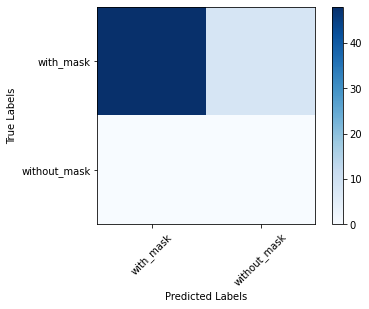

array([[  48,    8],
       [   0,    0]])

In [ ]:
y_pred1 = []
y_true1 = []

# iterate over test data to get true and predicted labels
for inputs, labels in incorrect_use:
        output1 = net(inputs) 

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save predicted labels
        
        labels = labels.data.cpu().numpy()
        y_true1.extend(labels) # Save true labels
        
classes = ('with_mask', 'without_mask')

#Plot and compute confusion matrix
cm1 = confusion_matrix(y_true1, y_pred1)
plt.imshow(cm1, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
cm1

### d. Προτείνετε τρόπους (χωρίς απαραίτητα να υλοποιηθούν) που μπορεί να αυξηθεί ο αριθμός των εικόνων της κλάσης mask_incorrect_use που ταξινομούνται ως μη αποδεκτή χρήση μάσκας, χωρίς να επηρεαστούν σημαντικά τα αποτελέσματα στο test set. 

Ως πρώτος τρόπος είναι η δημιουργία καινούργιων  εικόνων από το ήδη υπάρχων dataset με pre-processing Augmentation. Ενας τρόπος είναι με την χρήση του Albumentations. Η συγκεκριμένη βιβλιοθήκη περιέχει πάνω από 70 διαφορετικές αυξήσεις για την δημιουργία νέων εικόνων.
Επίσης, θα μπορούσαμε να εισάγουμε θόρυβο στις εικόνες και να τις εισάγουμε και αυτές στο dataset. Ένας άλλος τρόπος είναι να διώξουμε τυχόν outliers, δηλαδή εικόνες που διαφέρουν πολύ από τον μέσο όρο των εικόνων. 
Τέλος, μπορούν να παραχθούν κάποια συνθετικά δεδομένα με την μέθοδο SMOTE - πρακτικά διαλέγει από την κλάση που είναι μειονότητα ένα τυχαίο σημείο και υπολογίζει το k-nearest neighbors για αυτό και προσθέτει συνθετικά σημεία μεταξύ του επιλεγμένου σημείου και των γειτόνων. 


In [ ]:
import torch
import torchvision.transforms as transforms
import glob
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import time
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [ ]:
# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
    def __init__(self, image_list):
        self.image_list = image_list
        self.aug = A.Compose({
        A.Resize(200, 300),
        A.CenterCrop(100, 100),
        A.RandomCrop(80, 80),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=(-90, 90)),
        A.VerticalFlip(p=0.5),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        })
         
    def __len__(self):
        return (len(self.image_list))
    
    def __getitem__(self, i):
        image = plt.imread(self.image_list[i])
        image = Image.fromarray(image).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
            
        return torch.tensor(image, dtype=torch.float)

In [ ]:
alb_dataset = AlbumentationImageDataset(image_list=root_dest1)
alb_dataloader = DataLoader(dataset=alb_dataset, batch_size=16, shuffle=True)

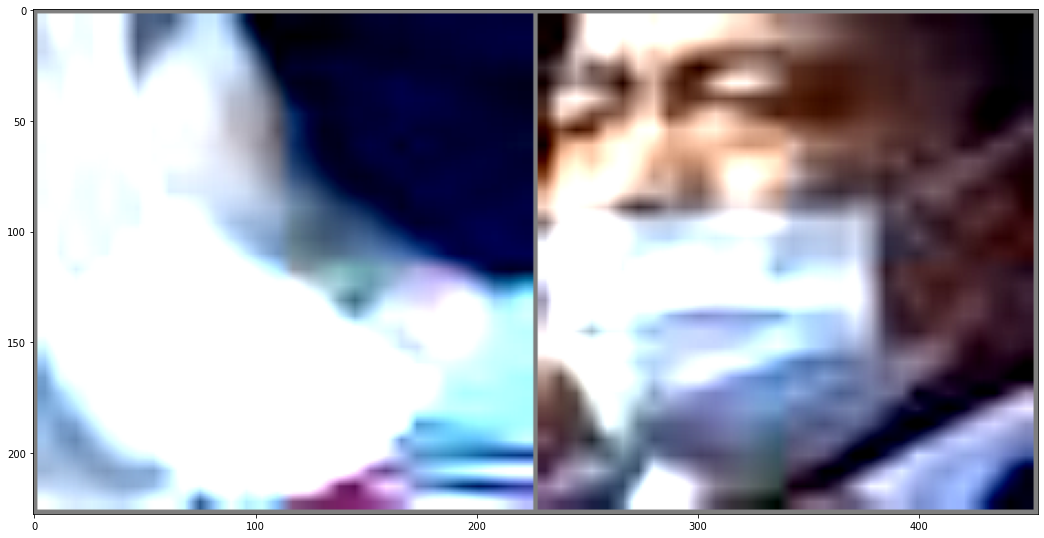

In [ ]:
def show_img(img):
    plt.figure(figsize=(18,15))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
show_img(torchvision.utils.make_grid(images))

In [ ]:
net.eval()                                     # step i.
correct2 = 0
total2 = 0
for images, labels in incorrect_use:
    images = Variable(images.float())
    outputs2 = net(images)                      # step ii.
    _, predicted2 = torch.max(outputs2.data, 1)  # step iii.
    total2 += labels.size(0)
    correct2 += (predicted2 == labels).sum()     # step iv.

print('Test Accuracy of the model on  test images: %.4f %%' % (100 * correct2 / total2))

Test Accuracy of the model on  test images: 85.7143 %


In [ ]:
image_list = glob.glob('..content/drive/MyDrive/Mask_DB1/mask_incorrect_use/*.jpg')
image_list

[]